In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install contractions
!pip install keras~=2.12

In [6]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf
import nltk

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow.keras.models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout, LSTM, GRU
from tensorflow.keras import metrics
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import models
from keras import layers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## import of data and EDA

In [9]:
data= pd.read_table('/content/drive/MyDrive/fake reviews dataset.csv',sep=',')

In [10]:
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [12]:
data['category'].unique()

array(['Home_and_Kitchen_5', 'Sports_and_Outdoors_5', 'Electronics_5',
       'Movies_and_TV_5', 'Tools_and_Home_Improvement_5',
       'Pet_Supplies_5', 'Kindle_Store_5', 'Books_5', 'Toys_and_Games_5',
       'Clothing_Shoes_and_Jewelry_5'], dtype=object)

<Axes: xlabel='label', ylabel='count'>

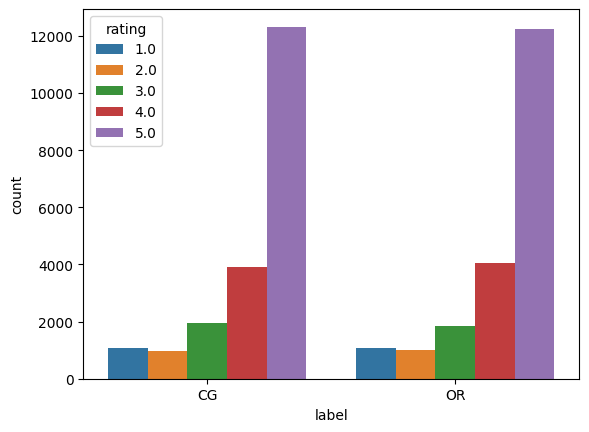

In [13]:
sns.countplot(x='label', hue='rating', data=data)

<Axes: xlabel='label', ylabel='count'>

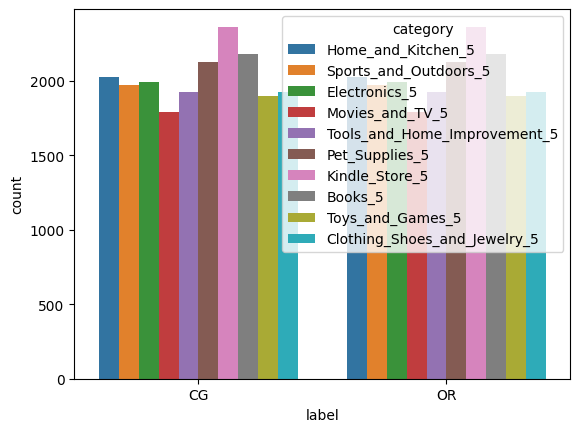

In [14]:
sns.countplot(x='label', hue='category', data=data)

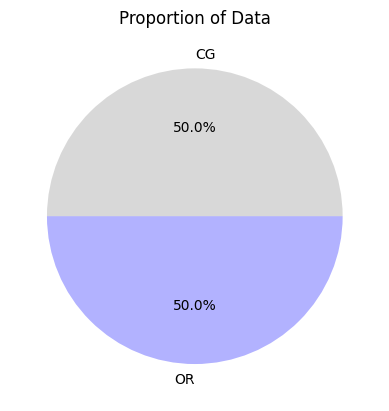

In [15]:
data.groupby('label').size().plot(kind = 'pie',autopct = '%1.1f%%',colors=['gray', 'blue'])
plt.title('Proportion of Data')
# Get the current axes object
ax = plt.gca()

# Set the alpha value for each wedge
for wedge in ax.patches:
    wedge.set_alpha(0.3)

In [16]:
data = data.drop(['category', 'rating'], axis=1) #Dropping useless variables
data.tail()

,label,text_
40427,OR,I had read some reviews saying that this bra r...
40428,CG,I wasn't sure exactly what it would be. It is ...
40429,OR,"You can wear the hood by itself, wear it with ..."
40430,CG,I liked nothing about this dress. The only rea...
40431,OR,I work in the wedding industry and have to wor...


## Preprocessing using Universal Sentence Encoder's TF Hub module

In [17]:
all_sentences  = []
for ind_ in range(data.shape[0]):
    all_sentences.append(data['text_'].iloc[ind_])

In [18]:
sent_embeddings = embed(all_sentences)

In [19]:
array_embeddings = sent_embeddings.numpy()
df_new = pd.DataFrame(array_embeddings)
df_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.006940,0.011810,-0.031482,0.015633,0.008974,-0.026224,0.010674,0.077475,0.020918,-0.002646,-0.031919,0.016407,-0.003788,-0.029800,0.005028,0.055849,0.028312,-0.013105,-0.013182,0.015781,-0.041271,-0.039305,0.095721,0.024133,-0.004673,0.015933,-0.046441,-0.055772,-0.020035,-0.017139,0.090775,0.034972,-0.037358,-0.025351,-0.031686,0.005412,0.000011,0.036809,-0.014078,-0.015069,...,0.039998,-0.025479,-0.020822,0.045090,-0.042153,0.011212,0.097439,-0.087797,0.076173,0.005674,0.072871,-0.045531,-0.049568,0.066396,-0.034196,0.023837,-0.013522,0.054883,0.026566,0.047704,0.038926,-0.072508,0.088854,-0.036727,-0.009280,-0.011780,-0.030984,0.022418,-0.019591,0.075693,-0.051523,0.040347,0.023136,0.011924,0.005779,-0.019653,-0.011959,-0.010591,0.024716,-0.016628
1,0.039856,-0.088555,-0.062387,-0.052907,-0.101541,0.016622,0.012015,0.053630,0.037416,-0.059812,-0.069733,0.001933,-0.036076,0.073494,-0.000113,0.103327,-0.037814,0.014138,0.014459,-0.049085,0.009653,0.018301,0.084873,0.049983,-0.027117,0.005716,0.042448,-0.019505,0.031004,0.038681,-0.012764,-0.031385,0.013992,0.026807,0.006334,0.038902,0.006387,-0.031040,-0.008071,-0.034637,...,0.020735,-0.010789,-0.022598,-0.028659,-0.044096,-0.006482,0.112212,-0.077638,0.006241,-0.038019,0.091350,0.001849,0.002159,0.022976,-0.028525,0.032003,-0.004060,0.036934,0.055108,0.023165,-0.038543,-0.059505,0.030431,-0.020116,0.096302,0.005585,-0.005007,0.032787,0.030950,-0.018910,-0.085796,0.045896,0.032539,-0.002595,-0.055771,0.039713,0.052477,-0.025806,-0.000132,0.017524
2,0.026452,0.049890,-0.006833,-0.012408,-0.028597,0.001728,-0.007391,0.039793,0.030889,0.052765,-0.004689,0.024890,0.027447,-0.037974,0.053953,0.020604,0.040999,0.026305,-0.075502,0.006954,0.045937,0.074507,0.075285,0.040548,0.002786,0.065224,0.014074,-0.075097,0.073820,-0.062768,0.064226,-0.017648,0.007251,-0.051310,-0.042167,-0.034807,0.009444,0.060749,0.007412,0.065591,...,0.004780,-0.042618,-0.025657,0.008129,-0.037383,0.046498,0.081383,-0.088959,0.079645,0.029595,0.019800,0.000089,-0.051012,-0.006233,-0.069252,-0.008547,-0.002959,-0.074770,0.051690,-0.001893,0.035911,-0.008718,0.056729,-0.029473,-0.014375,0.044141,0.024137,0.001559,-0.022664,0.073772,0.064424,0.032969,-0.013867,-0.069442,-0.020779,-0.019801,0.006518,0.066999,0.075028,-0.036810
3,0.016859,-0.055331,-0.025919,-0.019537,0.007819,-0.001818,0.016751,0.046662,0.073253,-0.078695,-0.022818,0.028059,0.032547,0.005286,-0.028957,0.065868,-0.004291,0.012955,-0.033675,-0.023004,0.031682,-0.010519,0.017727,-0.036763,-0.043302,-0.000525,0.011195,0.031390,0.030975,-0.028925,-0.046694,0.015081,0.008508,0.015539,-0.016932,0.035690,-0.051546,0.012749,0.028990,0.010573,...,0.004764,0.033475,0.090134,-0.085163,0.056793,-0.008411,0.085343,-0.029620,0.039988,-0.081371,0.053108,-0.065963,-0.016932,0.034236,0.087980,0.002373,0.054721,-0.057383,0.110200,0.005837,0.038687,-0.025064,0.071351,0.058408,0.021983,0.024955,-0.023226,0.042408,-0.024673,0.063061,-0.022041,0.076432,0.021984,0.019978,0.005586,0.033138,-0.061893,-0.025038,-0.011382,0.022592
4,0.002613,-0.074271,-0.000878,0.002128,-0.017470,0.016206,-0.022090,0.022078,-0.057446,-0.043721,-0.040543,0.041056,-0.064514,0.064914,0.024566,0.094727,-0.007178,-0.010421,0.039173,0.028516,0.044433,-0.025107,0.075148,0.059642,-0.058376,0.010610,0.056301,0.052004,0.005088,0.010136,0.017107,0.043172,0.014870,-0.023614,-0.040375,0.033510,0.021076,-0.032561,-0.004531,0.001353,...,-0.056226,0.028273,-0.029172,0.023352,0.018653,-0.065255,0.105254,-0.090100,-0.009575,0.016341,0.064667,-0.006719,-0.054759,-0.021748,0.009031,-0.039806,-0.035994,0.055945,0.038152,0.069392,-0.004651,-0.004901,-0.036741,0.054427,-0.072102,-0.032032,0.043805,0.016567,-0.007686,0.046005,-0.046898,0.0

In [20]:
colum = ["feat_"+str(i+1) for i in range(512)]

df_new.columns = colum


In [21]:
df_new['label'] = data['label'].values
df_new.columns

Index(['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7',
       'feat_8', 'feat_9', 'feat_10',
       ...
       'feat_504', 'feat_505', 'feat_506', 'feat_507', 'feat_508', 'feat_509',
       'feat_510', 'feat_511', 'feat_512', 'label'],
      dtype='object', length=513)

In [22]:
X_train, X_rem, y_train, y_rem = train_test_split(df_new[colum], np.array(pd.get_dummies(df_new['label'].values)), 
                                                    train_size=0.7, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, train_size=0.5, random_state=42)

In [23]:
print('X_train :', X_train.shape)  
print('X_test :', X_test.shape)

print('X_val :', X_val.shape)  
print('y_val :', y_val.shape)

print('X_test :', X_test.shape)  
print('y_test :', y_test.shape)

X_train : (28302, 512)
X_test : (6065, 512)
X_val : (6065, 512)
y_val : (6065, 2)
X_test : (6065, 512)
y_test : (6065, 2)


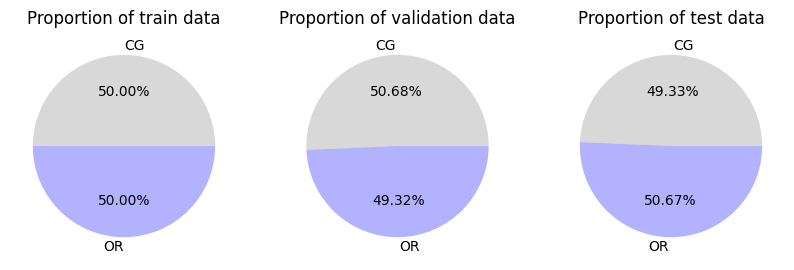

In [24]:
fig = plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
prop_tr= [np.argmax(i) for i in y_train]
prop_tr = pd.DataFrame(prop_tr,columns = ['y_tr'])
prop_tr.groupby('y_tr').size().plot(kind = 'pie',autopct = '%1.2f%%',colors=['gray', 'b'], labels=['CG','OR'])
plt.title('Proportion of train data')

ax = plt.gca()

# Set the alpha value for each wedge
for wedge in ax.patches:
    wedge.set_alpha(0.3)

plt.subplot(1,3,2)
prop_va= [np.argmax(i) for i in y_val]
prop_va = pd.DataFrame(prop_va,columns = ['y_va'])
prop_va.groupby('y_va').size().plot(kind = 'pie',autopct = '%1.2f%%',colors=['gray', 'b'], labels=['CG','OR'])
plt.title('Proportion of validation data')
ax = plt.gca()

# Set the alpha value for each wedge
for wedge in ax.patches:
    wedge.set_alpha(0.3)

plt.subplot(1,3,3)
prop_te= [np.argmax(i) for i in y_test]
prop_te = pd.DataFrame(prop_te,columns = ['y_te'])
prop_te.groupby('y_te').size().plot(kind = 'pie',autopct = '%1.2f%%',colors=['gray', 'b'], labels=['CG','OR'])
plt.title('Proportion of test data')

ax = plt.gca()

# Set the alpha value for each wedge
for wedge in ax.patches:
    wedge.set_alpha(0.3)


# MODEL 0 : USE model 

In [25]:
def baseline():
  
    # Seeting a seed so we can reproduce the results
    #tf.random.set_seed(137)

    # Define the initialisation method
    #initializer = RandomNormal(mean = 0.0, stddev=0.01)

    # create a squential model
    model = Sequential()

    # add one fully connected layer
    model.add(Dense(56, input_dim=512, activation='relu')) 
  # Adding dropout to prevent overfitting
    model.add(Dropout(0.5))
    # add one fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # add one fully connected output layer with a sigmoid activation
    model.add(Dense(2, input_dim=512, activation='softmax'))

    # Define the loss function
    loss = CategoricalCrossentropy()
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

#  Initialise the model

In [26]:
model = baseline()

# Determine the number of trainable parameters

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                28728     
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               7296      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 36,282
Trainable params: 36,282
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fitting model 0
%%time
stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history = model.fit(X_train, y_train, batch_size=128, validation_data=(X_val, y_val), epochs = 20, callbacks=[stopping])

Epoch 1/20
222/222 [==============================] - 3s 6ms/step - loss: 0.4807 - accuracy: 0.7671 - val_loss: 0.3638 - val_accuracy: 0.8320
Epoch 2/20
222/222 [==============================] - 1s 5ms/step - loss: 0.3622 - accuracy: 0.8369 - val_loss: 0.3444 - val_accuracy: 0.8399
Epoch 3/20
222/222 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.8472 - val_loss: 0.3350 - val_accuracy: 0.8445
Epoch 4/20
222/222 [==============================] - 1s 5ms/step - loss: 0.3258 - accuracy: 0.8523 - val_loss: 0.3266 - val_accuracy: 0.8509
Epoch 5/20
222/222 [==============================] - 1s 4ms/step - loss: 0.3131 - accuracy: 0.8629 - val_loss: 0.3189 - val_accuracy: 0.8528
Epoch 6/20
222/222 [==============================] - 1s 4ms/step - loss: 0.3034 - accuracy: 0.8673 - val_loss: 0.3153 - val_accuracy: 0.8585
Epoch 7/20
222/222 [==============================] - 1s 4ms/step - loss: 0.2898 - accuracy: 0.8731 - val_loss: 0.3124 - val_accuracy: 0.8597
Epoch 

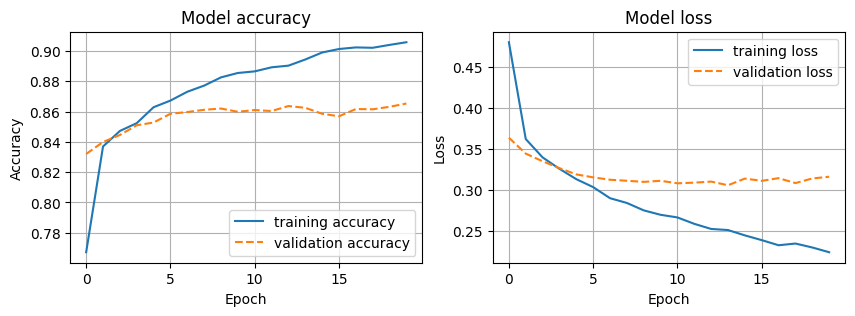

In [29]:
def modelplot_Drop():
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='training accuracy')
  plt.plot(history.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='lower right')
  
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history['val_loss'], label='validation loss', linestyle='dashed')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='upper right')
  
  plt.show()

modelplot_Drop()

In [30]:
evaluation = model.evaluate(X_test, y_test, verbose=0)
print("Loss : ",evaluation[0]) 
print("Accuracy : ",evaluation[1])

Loss :  0.30408498644828796
Accuracy :  0.8699092864990234


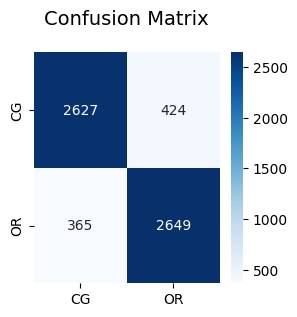

In [31]:
# Make prediction

prediction = model.predict(X_test, verbose=0)

#CONFUSION MATRIX

pred=[np.argmax(i) for i in prediction]
test =[np.argmax(i) for i in y_test]

cm_matrix=confusion_matrix(pred , test)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.figure(figsize=(3,3), dpi=100)
ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')

# set x-axis label and ticks. 
ax.xaxis.set_ticklabels(['CG', 'OR'])

# set y-axis label and ticks
ax.yaxis.set_ticklabels(['CG', 'OR'])

# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

In [32]:
# Generate the classification report
report = classification_report(test, pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2992
           1       0.88      0.86      0.87      3073

    accuracy                           0.87      6065
   macro avg       0.87      0.87      0.87      6065
weighted avg       0.87      0.87      0.87      6065



Specificity : 0.8780080213903744
F1-score : 87.0379 %
Score AUC : 0.8700160510466353


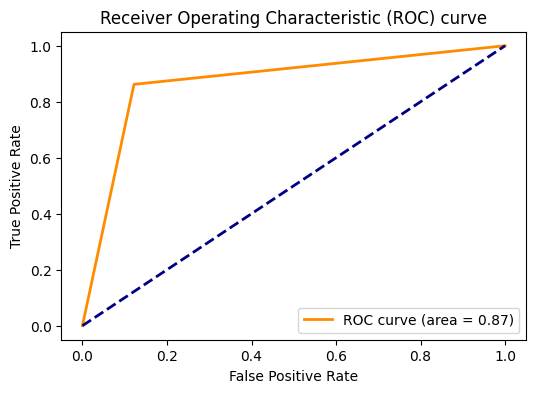

In [33]:
#Specificity
tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
print('Specificity :', tn / (tn + fp))

print("F1-score :", (f1_score(pred , test)*100).round(4), '%') #F1-score
print("Score AUC :", roc_auc_score(test, pred)) #AUC score

fpr, tpr, thresholds = roc_curve(test, pred) #Curve ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# WORD EMBEDDING MODELS 

In [34]:
# IMPORTS

import codecs

import string
import spacy
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, LSTM, Dropout, Dense, Flatten, Input, Embedding, GRU 
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [35]:
nlp = spacy.load('en_core_web_sm')
print('spaCy Version: %s' % (spacy.__version__))

spaCy Version: 3.5.2


## Data preprocessing and visualization

In [36]:
# Preprocess data 

def key_tokens(row): 
  # split into tokens by white space
  tokens = row.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation 
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic and lowercases the text 
  tokens = [word.lower() for word in tokens if word.isalpha()]
  # Remove out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if w not in stop_words]
  # stemming 
  porter = PorterStemmer()
  stemmed = [porter.stem(word) for word in tokens]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

In [37]:
%%time
data['text_'] = data.text_.apply(lambda row: key_tokens(row))
for index, row in data.iterrows():
    print(index, row['text_'],"tokens : {}".format(row['text_']))

Output hidden; open in https://colab.research.google.com to view.

In [38]:
data.sample(5)

,label,text_
6055,CG,"[great, die, old, burris, one, one, pretty, go..."
7953,OR,"[red, kettlebell, gofit, time, writing, review..."
39708,OR,"[absolutely, love, shoes, like, springs, walki..."
996,OR,"[great, cloths, little, larger, prefer, good, ..."
14696,CG,"[massimo, troisis, last, work, director, movie..."


In [39]:
# When some package do not install with !pip install --- 
import locale
print(locale.getpreferredencoding())

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

ANSI_X3.4-1968


### Create WORDCLOUDS

In [40]:
# iterate through the csv file
def plot_wordcloud(reviews, title):
    """ Generate wordcloud"""
    
    stopwords = set(STOPWORDS)
    comment_words = ""
    for tokens in reviews:
        comment_words += " ".join(tokens)+" "
        
    wordcloud = WordCloud(
        width = 800, 
        height = 800,
        background_color ='white',
        stopwords = stopwords,
        min_font_size = 10
    ).generate(comment_words)

    # plot the WordCloud image                       
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=20)
    plt.show()

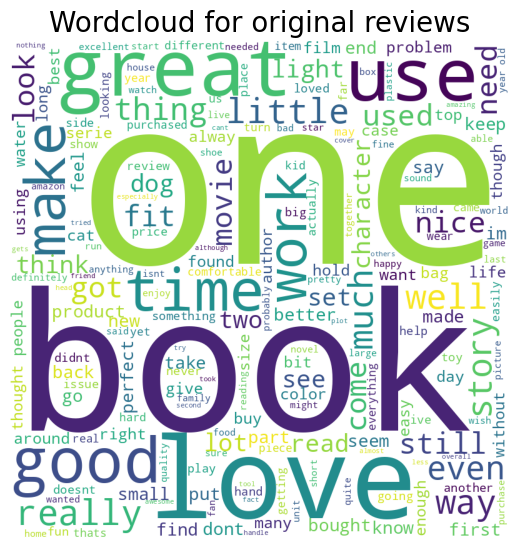

In [41]:
# WORD cloud positive reviews
title = "Wordcloud for original reviews"
OR = data[data.label == 'OR']['text_']
plot_wordcloud(OR, title)

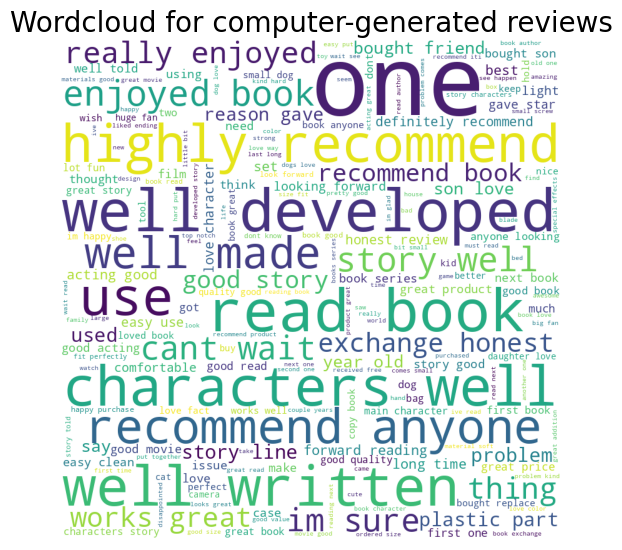

In [42]:
# WORD cloud computer-generated reviews
title = "Wordcloud for computer-generated reviews"
CG = data[data.label == 'CG']['text_']
plot_wordcloud(CG, title)

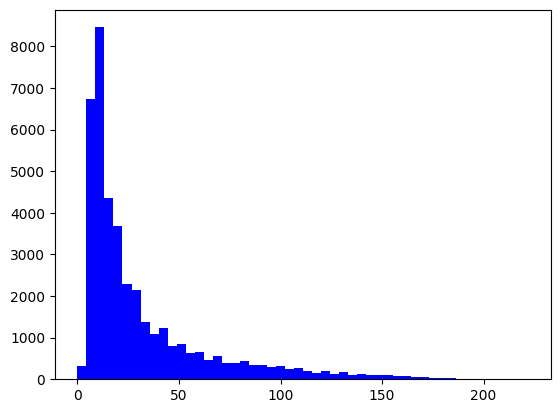

In [43]:
# Looking at the optimal review length 

review_lens = data['text_'].apply(lambda x: len(x))  
n, bins, patches = plt.hist(review_lens, 50, density=False, facecolor='b')

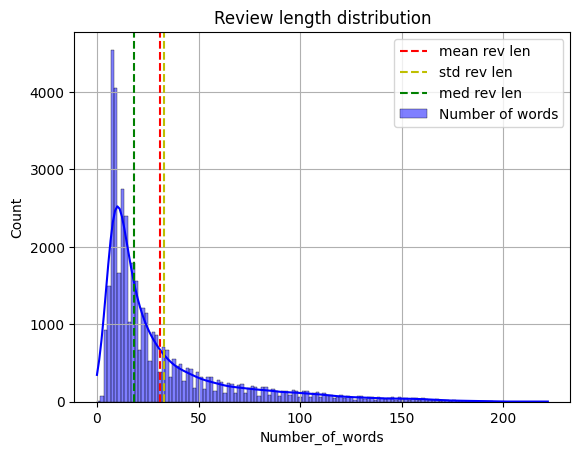

In [44]:
# Add number of words column and get some basic statistics

data['Number_of_words'] = data['text_'].str.len()
mean_len_rev = np.round(data['Number_of_words'].mean()).astype(int)
std_len_rev = np.round(data['Number_of_words'].std()).astype(int)
med_len_rev = np.round(data['Number_of_words'].median()).astype(int)
sns.histplot(data['Number_of_words'], kde=True, color='b', label='Number of words')
plt.axvline(x=mean_len_rev, color='r', linestyle='--', label='mean rev len')
plt.axvline(x=std_len_rev, color='y', linestyle='--', label='std rev len')
plt.axvline(x=med_len_rev, color='green', linestyle='--', label='med rev len')
plt.title('Review length distribution'); plt.legend()
plt.grid()
plt.show()

In [45]:
print("Max review lenght :", data["Number_of_words"].max())
print("Min review lenght :", data["Number_of_words"].min())
print("Mean review lenght :", data["Number_of_words"].mean())
print("Median review lenght :", data["Number_of_words"].median())
print("Std review lenght :", data["Number_of_words"].std())

Max review lenght : 222
Min review lenght : 0
Mean review lenght : 31.472818559556785
Median review lenght : 18.0
Std review lenght : 32.93381917557955


In [46]:
# Separeta features and target (encoded)
X = data['text_']
y = data['label'].apply(lambda x: 1 if x == 'OR' else 0) 

In [47]:
# Data Splitting into train, validation and test set 

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42) #Train set
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, train_size=0.5) #Validation and test set 

In [48]:
#Checking the proportions 

print('X_train :', X_train.shape)  
print('X_test :', X_test.shape)
print('X_val :', X_val.shape)  
print('y_val :', y_val.shape)
print('X_test :', X_test.shape)  
print('y_test :', y_test.shape)

X_train : (28302,)
X_test : (6065,)
X_val : (6065,)
y_val : (6065,)
X_test : (6065,)
y_test : (6065,)


In [49]:
# Convert text to integer 

tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [50]:
# Get the vocabulary size and the maximum review length

vocab_size = len(tokenizer.word_index) + 1
print("the vocabulary size is", vocab_size)

maxlen = 100 # Maximum length of a review
X_train=pad_sequences(X_train, padding='post' , maxlen=maxlen)
X_val=pad_sequences(X_val, padding='post' , maxlen=maxlen)
X_test=pad_sequences(X_test, padding='post' , maxlen=maxlen)

the vocabulary size is 39407


## GloVe embeddings

In [51]:
# Loading GloVe embedding 100-dimensional

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Finally, we will create a matrix where the row numbers of the matrix correspond to the index numbers for all the unique words in 
our dataset, and the columns contain the corresponding word embedding matrix from the Glove word embedding

In [52]:
# first create a matrix of zeros, this is our embedding matrix
embedding_dim = 300 
max_features = 40000
embedding_matrix = np.zeros((vocab_size, embedding_dim)) 

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in tokenizer.word_index.items():
  if i > max_features:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
  # we found the word - add that words vector to the matrix
    embedding_matrix[i] = embedding_vector
  else:
  # doesn't exist, assign a random vector
    embedding_matrix[i] = np.random.randn(embedding_dim)

In [53]:
# Shape of the embedding matrix 
embedding_matrix.shape 

(39407, 300)

### Model 1 : LSTM with GloVe embeddings

In [56]:
## Define the model 1 architecture

model1 = Sequential()
# embedding layer
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
#LSTM layer
model1.add(LSTM(units=128, dropout=0.3))
# Output layer
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

# Compile the model 1
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          11822100  
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12,041,877
Trainable params: 219,777
Non-trainable params: 11,822,100
_________________________________________________________________


In [57]:
%%time
# Fitting model 1
stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
history1 = model1.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val), callbacks=[stopping])

Epoch 1/20
222/222 [==============================] - 6s 14ms/step - loss: 0.6225 - accuracy: 0.6276 - val_loss: 0.4867 - val_accuracy: 0.7657
Epoch 2/20
222/222 [==============================] - 3s 12ms/step - loss: 0.4622 - accuracy: 0.7789 - val_loss: 0.4483 - val_accuracy: 0.8018
Epoch 3/20
222/222 [==============================] - 3s 12ms/step - loss: 0.3947 - accuracy: 0.8168 - val_loss: 0.3511 - val_accuracy: 0.8432
Epoch 4/20
222/222 [==============================] - 3s 13ms/step - loss: 0.3350 - accuracy: 0.8496 - val_loss: 0.3825 - val_accuracy: 0.8477
Epoch 5/20
222/222 [==============================] - 3s 12ms/step - loss: 0.3004 - accuracy: 0.8666 - val_loss: 0.2880 - val_accuracy: 0.8714
Epoch 6/20
222/222 [==============================] - 3s 12ms/step - loss: 0.2611 - accuracy: 0.8881 - val_loss: 0.2845 - val_accuracy: 0.8821
Epoch 7/20
222/222 [==============================] - 3s 12ms/step - loss: 0.2472 - accuracy: 0.8941 - val_loss: 0.2994 - val_accuracy: 0.8963

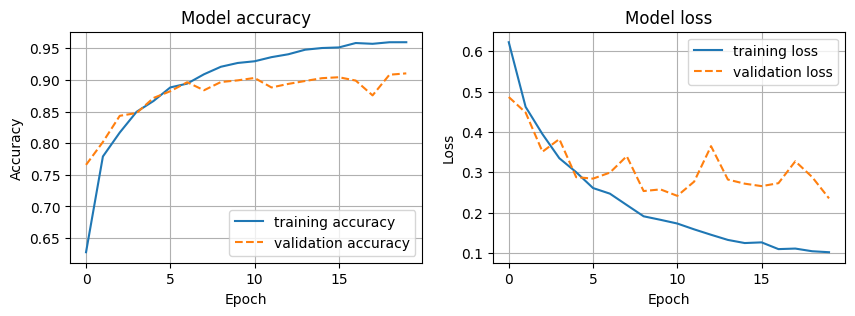

In [58]:
# Plot of acc and loss

def modelplot_Drop1():
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.plot(history1.history['accuracy'], label='training accuracy')
  plt.plot(history1.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='lower right')
  
  plt.subplot(1, 2, 2)
  plt.plot(history1.history['loss'], label='training loss')
  plt.plot(history1.history['val_loss'], label='validation loss', linestyle='dashed')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='upper right')
  
  plt.show()

modelplot_Drop1()

In [59]:
# Evaluation with test set 

evaluation1 = model1.evaluate(X_test, y_test)
print("Loss : ",evaluation1[0]) 
print("Accuracy : ",evaluation1[1])

190/190 [==============================] - 1s 5ms/step - loss: 0.2453 - accuracy: 0.9035
Loss :  0.2453121542930603
Accuracy :  0.9035449028015137


190/190 [==============================] - 1s 3ms/step


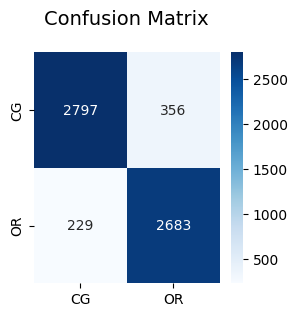

In [60]:
# Make prediction
prediction1 = model1.predict(X_test)

#CONFUSION MATRIX

pred=[np.round(i) for i in prediction1]
test =[np.round(i) for i in y_test]

cm_matrix=confusion_matrix(pred , test)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.figure(figsize=(3,3), dpi=100)
ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')

ax.xaxis.set_ticklabels(['CG', 'OR']) # set x-axis label and ticks.
ax.yaxis.set_ticklabels(['CG', 'OR']) # set y-axis label and ticks
ax.set_title("Confusion Matrix", fontsize=14, pad=20) # Plot title

plt.show()

In [61]:
print('F1-score of GloVe with LSTM is', f1_score(pred , test)) 

F1-score of GloVe with LSTM is 0.9016971937489497


In [62]:
# Generate the classification report
report = classification_report(test, pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3026
           1       0.92      0.88      0.90      3039

    accuracy                           0.90      6065
   macro avg       0.90      0.90      0.90      6065
weighted avg       0.90      0.90      0.90      6065



Specificity : 0.9243225380039656
F1-score : 90.1697 %
Score AUC : 0.9035893703511109


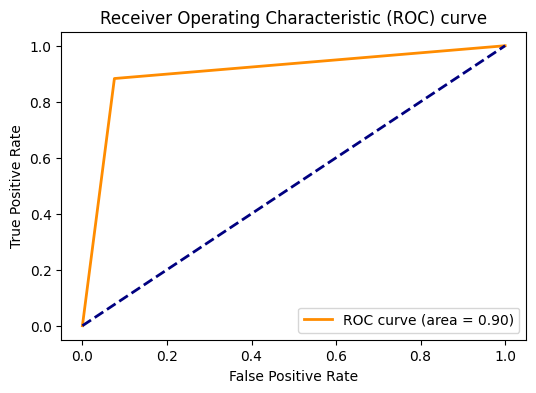

In [63]:
#Specificity
tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
print('Specificity :', tn / (tn + fp))

print("F1-score :", (f1_score(pred , test)*100).round(4), '%') #F1-score
print("Score AUC :", roc_auc_score(test, pred)) #AUC score

fpr, tpr, thresholds = roc_curve(test, pred) #Curve ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

### Model 2 : GRU with GloVe embeddings  

In [66]:
# GRU architecture 
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, trainable = False, weights=[embedding_matrix]))
model2.add(GRU(64)) 
model2.add(Dropout(0.8))
model2.add(Dense(1, activation = 'sigmoid'))
#Compile model 2
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         11822100  
                                                                 
 gru_1 (GRU)                 (None, 64)                70272     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,892,437
Trainable params: 70,337
Non-trainable params: 11,822,100
_________________________________________________________________
None


In [67]:
%%time
# Fitting model 2
stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[stopping])

Epoch 1/20
443/443 [==============================] - 7s 9ms/step - loss: 0.6772 - accuracy: 0.5546 - val_loss: 0.6038 - val_accuracy: 0.6905
Epoch 2/20
443/443 [==============================] - 3s 7ms/step - loss: 0.4970 - accuracy: 0.7642 - val_loss: 0.4148 - val_accuracy: 0.8053
Epoch 3/20
443/443 [==============================] - 4s 8ms/step - loss: 0.3490 - accuracy: 0.8457 - val_loss: 0.3011 - val_accuracy: 0.8620
Epoch 4/20
443/443 [==============================] - 3s 7ms/step - loss: 0.2639 - accuracy: 0.8870 - val_loss: 0.2717 - val_accuracy: 0.8778
Epoch 5/20
443/443 [==============================] - 3s 6ms/step - loss: 0.2156 - accuracy: 0.9086 - val_loss: 0.2807 - val_accuracy: 0.8871
Epoch 6/20
443/443 [==============================] - 3s 6ms/step - loss: 0.1774 - accuracy: 0.9273 - val_loss: 0.2583 - val_accuracy: 0.8922
Epoch 7/20
443/443 [==============================] - 4s 9ms/step - loss: 0.1494 - accuracy: 0.9393 - val_loss: 0.2932 - val_accuracy: 0.8950
Epoch 

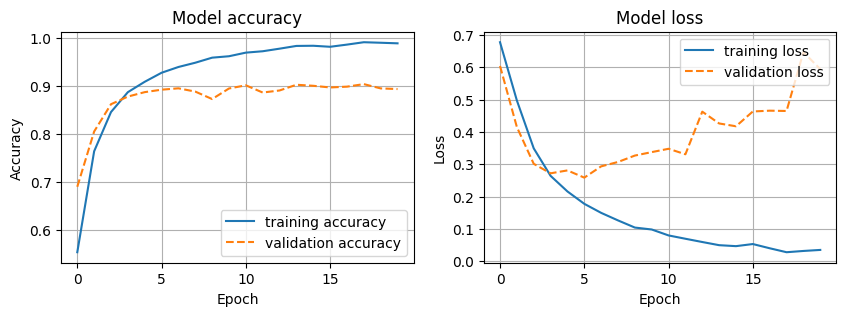

In [68]:
# Plot of acc and loss

def modelplot_Drop2():
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.plot(history2.history['accuracy'], label='training accuracy')
  plt.plot(history2.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='lower right')
  
  plt.subplot(1, 2, 2)
  plt.plot(history2.history['loss'], label='training loss')
  plt.plot(history2.history['val_loss'], label='validation loss', linestyle='dashed')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='upper right')
  
  plt.show()

modelplot_Drop2()

In [69]:
# Evaluation with test set 

evaluation2 = model2.evaluate(X_test, y_test)
print("Loss : ",evaluation2[0]) 
print("Accuracy : ",evaluation2[1])

190/190 [==============================] - 1s 4ms/step - loss: 0.6111 - accuracy: 0.8892
Loss :  0.6110666990280151
Accuracy :  0.8892003297805786


In [70]:
# Make prediction
prediction2 = model2.predict(X_test)

190/190 [==============================] - 1s 3ms/step


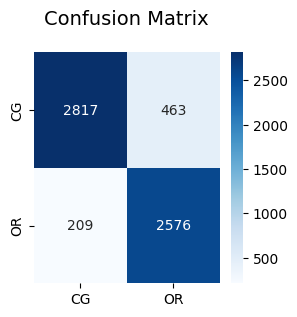

In [71]:
#CONFUSION MATRIX

pred=[np.round(i) for i in prediction2]
test =[np.round(i) for i in y_test]

cm_matrix=confusion_matrix(pred , test)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.figure(figsize=(3,3), dpi=100)
ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
ax.xaxis.set_ticklabels(['CG', 'OR']) # set x-axis label and ticks.
ax.yaxis.set_ticklabels(['CG', 'OR']) # set y-axis label and ticks
ax.set_title("Confusion Matrix", fontsize=14, pad=20) # Plot title

plt.show()

In [72]:
# Generate the classification report
report = classification_report(test, pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3026
           1       0.92      0.85      0.88      3039

    accuracy                           0.89      6065
   macro avg       0.89      0.89      0.89      6065
weighted avg       0.89      0.89      0.89      6065



Specificity : 0.9309319233311302
F1-score : 88.4615 %
Score AUC : 0.8892895878583916


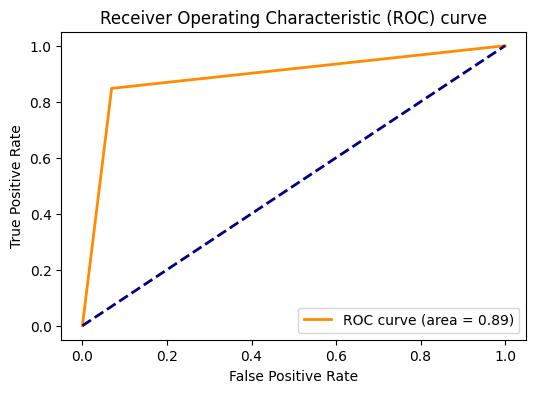

In [73]:
#Specificity
tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
print('Specificity :', tn / (tn + fp))

print("F1-score :", (f1_score(pred , test)*100).round(4), '%') #F1-score
print("Score AUC :", roc_auc_score(test, pred)) #AUC score

fpr, tpr, thresholds = roc_curve(test, pred) #Curve ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

## Word2vec models

In [74]:
# import 
from gensim.models import KeyedVectors

In [75]:
# Load the pre-trained word2vec embeddings (just 400000 1st common words with 300D-tensor)
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', 
                                                 binary=True, limit=400000)

In [76]:
# Define the vocabulary size and embedding dimensions
vocab_size = len(tokenizer.word_index) + 1  
embedding_dim = word_vectors.vector_size #embedding_dim=300

# Create an embedding matrix using the pre-trained word vectors
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(tokenizer.word_index):
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


In [77]:
# Check the tensor's shape 
vocab_size, embedding_dim, embedding_matrix.shape

(39407, 300, (39407, 300))

#### Evaluating word2vec embeddings

In [78]:
word_vectors.most_similar('banana') 

[('bananas', 0.7523775696754456),
 ('pineapple', 0.6587537527084351),
 ('mango', 0.6365211009979248),
 ('pineapples', 0.6313878297805786),
 ('papaya', 0.6063665747642517),
 ('coconut', 0.6035483479499817),
 ('potato', 0.5747568607330322),
 ('melon', 0.5625775456428528),
 ('cashew', 0.562165379524231),
 ('tomato', 0.5590206384658813)]

In [79]:
word_vectors.most_similar('love') 

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

### Model 3 : LSTM with Word2vec embeddings 

In [82]:
# Define the model architecture
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, 
                    weights=[embedding_matrix], trainable=False))
model3.add(LSTM(units=128, dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          11822100  
                                                                 
 lstm_3 (LSTM)               (None, 128)               219648    
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12,041,877
Trainable params: 219,777
Non-trainable params: 11,822,100
_________________________________________________________________


In [83]:
%%time
# Fitting model 3
stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history3 = model3.fit(X_train, y_train, batch_size=42, epochs=20, validation_data=(X_val, y_val), callbacks=[stopping])

Epoch 1/20
674/674 [==============================] - 9s 10ms/step - loss: 0.6846 - accuracy: 0.5254 - val_loss: 0.6736 - val_accuracy: 0.5428
Epoch 2/20
674/674 [==============================] - 5s 7ms/step - loss: 0.6772 - accuracy: 0.5415 - val_loss: 0.5893 - val_accuracy: 0.7120
Epoch 3/20
674/674 [==============================] - 5s 7ms/step - loss: 0.4775 - accuracy: 0.7710 - val_loss: 0.4576 - val_accuracy: 0.7919
Epoch 4/20
674/674 [==============================] - 6s 8ms/step - loss: 0.4072 - accuracy: 0.8100 - val_loss: 0.4102 - val_accuracy: 0.8106
Epoch 5/20
674/674 [==============================] - 5s 7ms/step - loss: 0.3639 - accuracy: 0.8339 - val_loss: 0.3654 - val_accuracy: 0.8407
Epoch 6/20
674/674 [==============================] - 6s 9ms/step - loss: 0.3336 - accuracy: 0.8509 - val_loss: 0.3985 - val_accuracy: 0.8099
Epoch 7/20
674/674 [==============================] - 5s 7ms/step - loss: 0.2979 - accuracy: 0.8666 - val_loss: 0.3273 - val_accuracy: 0.8547
Epoch

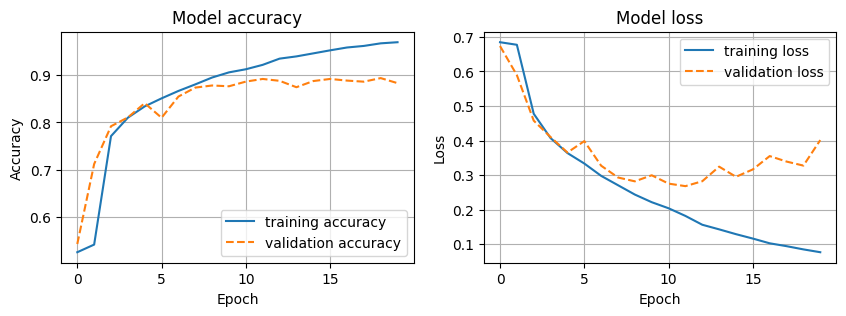

In [84]:
# Plot of acc and loss

def modelplot_Drop3():
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.plot(history3.history['accuracy'], label='training accuracy')
  plt.plot(history3.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='lower right')
  
  plt.subplot(1, 2, 2)
  plt.plot(history3.history['loss'], label='training loss')
  plt.plot(history3.history['val_loss'], label='validation loss', linestyle='dashed')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='upper right')
  
  plt.show()

modelplot_Drop3()

In [85]:
# Evaluation with test set 
evaluation3 = model3.evaluate(X_test, y_test, verbose=0)
print("Loss : ", evaluation3[0]) 
print("Accuracy : ", evaluation3[1])

Loss :  0.413096159696579
Accuracy :  0.8786479830741882


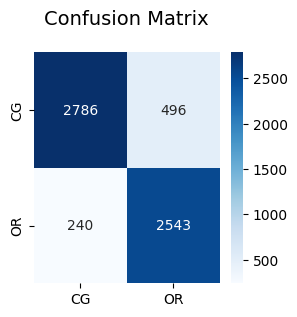

In [86]:
# Make prediction
prediction3 = model3.predict(X_test, verbose=0)

#CONFUSION MATRIX

pred=[np.round(i) for i in prediction3]
test =[np.round(i) for i in y_test]

cm_matrix=confusion_matrix(pred , test)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.figure(figsize=(3,3), dpi=100)
ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap="Blues")
ax.xaxis.set_ticklabels(['CG', 'OR']) # set x-axis label and ticks.
ax.yaxis.set_ticklabels(['CG', 'OR']) # set y-axis label and ticks
ax.set_title("Confusion Matrix", fontsize=14, pad=20) # Plot title

plt.show()

In [87]:
# Generate the classification report
report = classification_report(test, pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3026
           1       0.91      0.84      0.87      3039

    accuracy                           0.88      6065
   macro avg       0.88      0.88      0.88      6065
weighted avg       0.88      0.88      0.88      6065



Specificity : 0.9206873760740251
F1-score : 87.3583 %
Score AUC : 0.8787378966582695


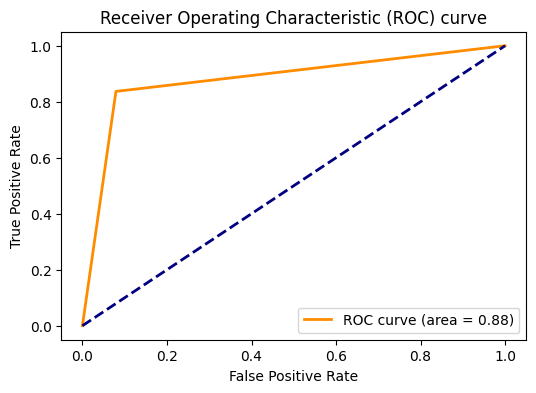

In [88]:
#Specificity
tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
print('Specificity :', tn / (tn + fp))

print("F1-score :", (f1_score(pred , test)*100).round(4), '%') #F1-score
print("Score AUC :", roc_auc_score(test, pred)) #AUC score

fpr, tpr, thresholds = roc_curve(test, pred) #Curve ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

### Model 4 : GRU with Word2vec embeddings 

In [89]:
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable = False, 
                        input_length=maxlen,weights=[embedding_matrix]))
model4.add(GRU(128, dropout=0.3))
model4.add(Dense(1, activation = 'sigmoid'))

#Compile 
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          11822100  
                                                                 
 gru_2 (GRU)                 (None, 128)               165120    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 11,987,349
Trainable params: 165,249
Non-trainable params: 11,822,100
_________________________________________________________________
None


In [90]:
%%time
# Fitting model 4
stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history4 = model4.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val), callbacks=[stopping])

Epoch 1/20
222/222 [==============================] - 6s 15ms/step - loss: 0.6906 - accuracy: 0.5184 - val_loss: 0.6966 - val_accuracy: 0.5281
Epoch 2/20
222/222 [==============================] - 2s 10ms/step - loss: 0.6861 - accuracy: 0.5183 - val_loss: 0.6903 - val_accuracy: 0.5268
Epoch 3/20
222/222 [==============================] - 2s 11ms/step - loss: 0.6225 - accuracy: 0.6117 - val_loss: 0.5338 - val_accuracy: 0.7309
Epoch 4/20
222/222 [==============================] - 2s 11ms/step - loss: 0.4627 - accuracy: 0.7764 - val_loss: 0.4222 - val_accuracy: 0.7980
Epoch 5/20
222/222 [==============================] - 2s 10ms/step - loss: 0.4036 - accuracy: 0.8113 - val_loss: 0.3985 - val_accuracy: 0.8209
Epoch 6/20
222/222 [==============================] - 3s 12ms/step - loss: 0.3581 - accuracy: 0.8342 - val_loss: 0.3420 - val_accuracy: 0.8473
Epoch 7/20
222/222 [==============================] - 2s 11ms/step - loss: 0.3254 - accuracy: 0.8545 - val_loss: 0.3081 - val_accuracy: 0.8650

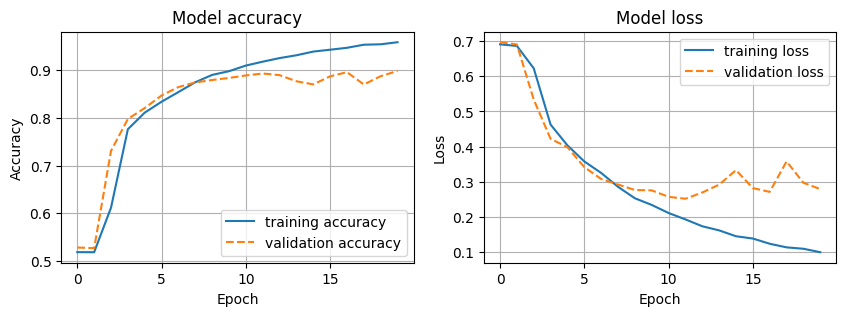

In [91]:
# Plot of acc and loss

def modelplot_Drop4():
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.plot(history4.history['accuracy'], label='training accuracy')
  plt.plot(history4.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='lower right')
  
  plt.subplot(1, 2, 2)
  plt.plot(history4.history['loss'], label='training loss')
  plt.plot(history4.history['val_loss'], label='validation loss', linestyle='dashed')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='upper right')
  
  plt.show()

modelplot_Drop4()

In [92]:
# Evaluation with test set 

evaluation4 = model4.evaluate(X_test, y_test, verbose=0)
print("Loss : ", evaluation4[0]) 
print("Accuracy : ", evaluation4[1])

Loss :  0.29955819249153137
Accuracy :  0.8920032978057861


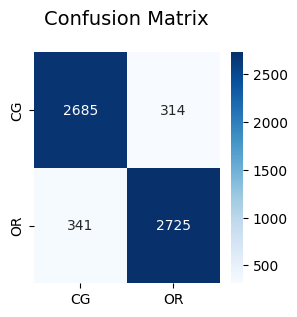

In [93]:
# Make prediction
prediction4 = model4.predict(X_test, verbose=0)

#CONFUSION MATRIX

pred=[np.round(i) for i in prediction4]
test =[np.round(i) for i in y_test]

cm_matrix=confusion_matrix(pred , test)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.figure(figsize=(3,3), dpi=100)
ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
ax.xaxis.set_ticklabels(['CG', 'OR']) # set x-axis label and ticks.
ax.yaxis.set_ticklabels(['CG', 'OR']) # set y-axis label and ticks
ax.set_title("Confusion Matrix", fontsize=14, pad=20) # Plot title

plt.show()

In [94]:
# Generate the classification report
report = classification_report(test, pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3026
           1       0.89      0.90      0.89      3039

    accuracy                           0.89      6065
   macro avg       0.89      0.89      0.89      6065
weighted avg       0.89      0.89      0.89      6065



Specificity : 0.887309980171844
F1-score : 89.2711 %
Score AUC : 0.8919932592534113


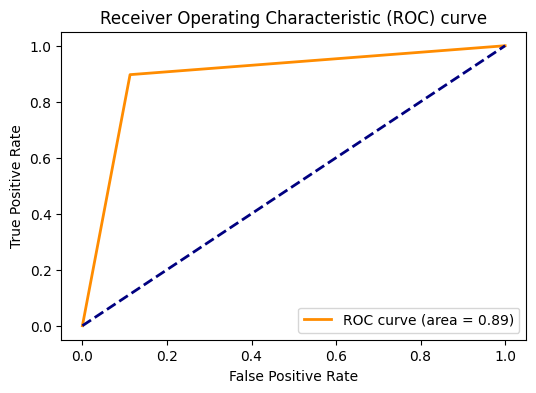

In [95]:
#Specificity
tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
print('Specificity :', tn / (tn + fp))

print("F1-score :", (f1_score(pred , test)*100).round(4), '%') #F1-score
print("Score AUC :", roc_auc_score(test, pred)) #AUC score

fpr, tpr, thresholds = roc_curve(test, pred) #Curve ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

## FastText embeddings

### Loading and getting the embedding matrix

In [ ]:
!pip install fasttext
!pip install torch

In [98]:
import fasttext
import gensim
import torch
from gensim.models import KeyedVectors

In [99]:
ft_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/crawl-300d-2M.vec', binary=False)

In [100]:
#Check the size of the data
temp_weights=torch.FloatTensor(ft_model.vectors)
print(temp_weights.shape)

torch.Size([1999995, 300])


In [ ]:
# Embedding matrix
vocab_size = len(tokenizer.word_index) + 1 #Same vocab size for all models 
embedding_dim = ft_model.vector_size #300D-tensor

embedding_matrix = np.random.random((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ft_model[word]
  except:
    print(word, 'not found')
  if embedding_vector is not None:
    embedding_matrix[i, :] = embedding_vector

In [103]:
embedding_matrix.shape

(39407, 300)

### Model 5 : LSTM with FastText embedding models 

In [133]:
## Network architecture 

tf.random.set_seed(137)
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model5.add(LSTM(units=128, dropout=0.3))
model5.add(Dense(1, activation='sigmoid'))

# Compile the model 5
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 300)          11822100  
                                                                 
 lstm_8 (LSTM)               (None, 128)               219648    
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,041,877
Trainable params: 219,777
Non-trainable params: 11,822,100
_________________________________________________________________


In [134]:
%%time
# Fitting model 5
stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history5 = model5.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[stopping])

Epoch 1/20
443/443 [==============================] - 8s 10ms/step - loss: 0.6178 - accuracy: 0.6208 - val_loss: 0.4658 - val_accuracy: 0.7789
Epoch 2/20
443/443 [==============================] - 4s 9ms/step - loss: 0.3904 - accuracy: 0.8196 - val_loss: 0.3295 - val_accuracy: 0.8508
Epoch 3/20
443/443 [==============================] - 4s 9ms/step - loss: 0.3296 - accuracy: 0.8502 - val_loss: 0.3167 - val_accuracy: 0.8580
Epoch 4/20
443/443 [==============================] - 4s 9ms/step - loss: 0.2869 - accuracy: 0.8695 - val_loss: 0.2741 - val_accuracy: 0.8780
Epoch 5/20
443/443 [==============================] - 4s 9ms/step - loss: 0.2456 - accuracy: 0.8904 - val_loss: 0.2633 - val_accuracy: 0.8786
Epoch 6/20
443/443 [==============================] - 4s 8ms/step - loss: 0.2228 - accuracy: 0.9029 - val_loss: 0.2288 - val_accuracy: 0.9029
Epoch 7/20
443/443 [==============================] - 4s 9ms/step - loss: 0.1958 - accuracy: 0.9150 - val_loss: 0.2174 - val_accuracy: 0.9054
Epoch

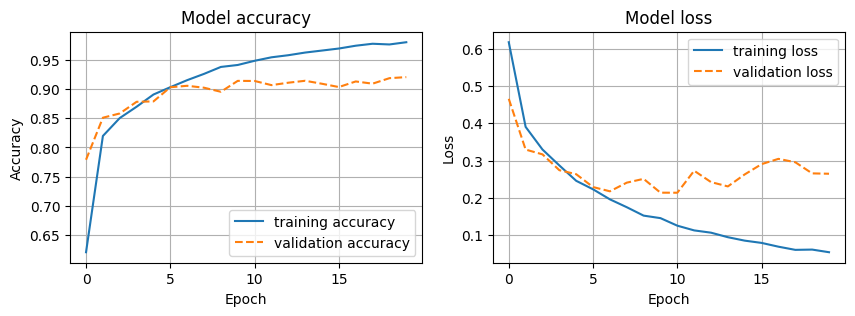

In [135]:
# Plot of acc and loss

def modelplot_Drop5():
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.plot(history5.history['accuracy'], label='training accuracy')
  plt.plot(history5.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='lower right')
  
  plt.subplot(1, 2, 2)
  plt.plot(history5.history['loss'], label='training loss')
  plt.plot(history5.history['val_loss'], label='validation loss', linestyle='dashed')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='upper right')
  
  plt.show()

modelplot_Drop5()

In [136]:
# Evaluation with test set 

evaluation5 = model5.evaluate(X_test, y_test, verbose=0)
print("Loss : ", evaluation5[0]) 
print("Accuracy : ", evaluation5[1])

Loss :  0.27486926317214966
Accuracy :  0.9193734526634216


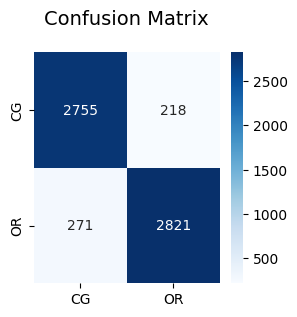

In [137]:
# Make prediction
prediction5 = model5.predict(X_test, verbose=0)

#CONFUSION MATRIX

pred=[np.round(i) for i in prediction5]
test =[np.round(i) for i in y_test]

cm_matrix=confusion_matrix(pred , test)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.figure(figsize=(3,3), dpi=100)
ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
ax.xaxis.set_ticklabels(['CG', 'OR']) # set x-axis label and ticks.
ax.yaxis.set_ticklabels(['CG', 'OR']) # set y-axis label and ticks
ax.set_title("Confusion Matrix", fontsize=14, pad=20) # Plot title

plt.show()

In [138]:
# Generate the classification report
report = classification_report(test, pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3026
           1       0.91      0.93      0.92      3039

    accuracy                           0.92      6065
   macro avg       0.92      0.92      0.92      6065
weighted avg       0.92      0.92      0.92      6065



Specificity : 0.9104428288169201
F1-score : 92.0241 %
Score AUC : 0.919354352875061


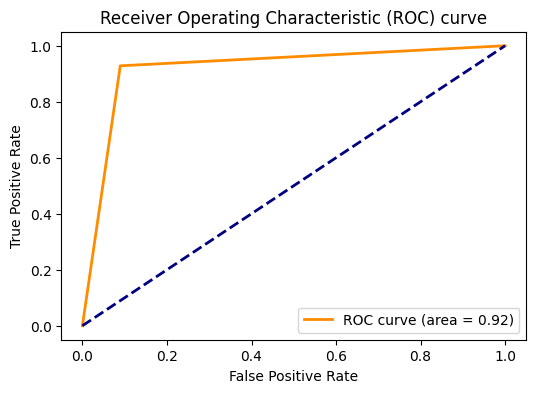

In [139]:
#Specificity
tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
print('Specificity :', tn / (tn + fp))

print("F1-score :", (f1_score(pred , test)*100).round(4), '%') #F1-score
print("Score AUC :", roc_auc_score(test, pred)) #AUC score

fpr, tpr, thresholds = roc_curve(test, pred) #Curve ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

### Model 6 : GRU with FastText embeddings

In [121]:
model6 = Sequential()
model6.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable = False, 
                        input_length=maxlen,weights=[embedding_matrix]))
model6.add(GRU(128, dropout=0.3))
model6.add(Dense(1, activation = 'sigmoid'))

#Compile 
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model6.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 300)          11822100  
                                                                 
 gru_3 (GRU)                 (None, 128)               165120    
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 11,987,349
Trainable params: 165,249
Non-trainable params: 11,822,100
_________________________________________________________________
None


In [122]:
%%time
# Fitting model 6
stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history6 = model6.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[stopping])

Epoch 1/20
885/885 [==============================] - 9s 7ms/step - loss: 0.5196 - accuracy: 0.7132 - val_loss: 0.4109 - val_accuracy: 0.8069
Epoch 2/20
885/885 [==============================] - 7s 8ms/step - loss: 0.3616 - accuracy: 0.8308 - val_loss: 0.3078 - val_accuracy: 0.8618
Epoch 3/20
885/885 [==============================] - 6s 7ms/step - loss: 0.2943 - accuracy: 0.8649 - val_loss: 0.2597 - val_accuracy: 0.8833
Epoch 4/20
885/885 [==============================] - 7s 8ms/step - loss: 0.2473 - accuracy: 0.8886 - val_loss: 0.2540 - val_accuracy: 0.8874
Epoch 5/20
885/885 [==============================] - 6s 7ms/step - loss: 0.2099 - accuracy: 0.9077 - val_loss: 0.2196 - val_accuracy: 0.9055
Epoch 6/20
885/885 [==============================] - 8s 8ms/step - loss: 0.1825 - accuracy: 0.9224 - val_loss: 0.2048 - val_accuracy: 0.9124
Epoch 7/20
885/885 [==============================] - 6s 7ms/step - loss: 0.1552 - accuracy: 0.9331 - val_loss: 0.2417 - val_accuracy: 0.8983
Epoch 

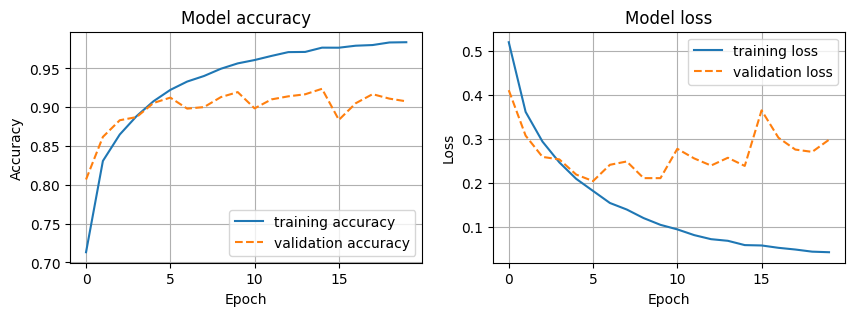

In [123]:
# Plot of acc and loss

def modelplot_Drop6():
  plt.figure(figsize=(10, 3))

  plt.subplot(1, 2, 1)
  plt.plot(history6.history['accuracy'], label='training accuracy')
  plt.plot(history6.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='lower right')
  
  plt.subplot(1, 2, 2)
  plt.plot(history6.history['loss'], label='training loss')
  plt.plot(history6.history['val_loss'], label='validation loss', linestyle='dashed')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(loc='upper right')
  
  plt.show()
modelplot_Drop6()  

In [124]:
# Evaluation with test set 

evaluation6 = model6.evaluate(X_test, y_test, verbose=0)
print("Loss : ", evaluation6[0]) 
print("Accuracy : ", evaluation6[1])

Loss :  0.28649625182151794
Accuracy :  0.9122835993766785


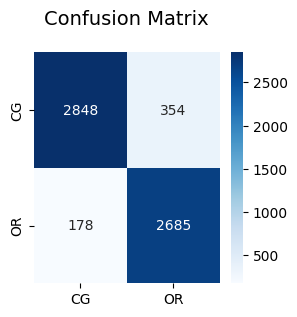

In [125]:
# Make prediction
prediction6 = model6.predict(X_test, verbose=0)

#CONFUSION MATRIX

pred=[np.round(i) for i in prediction6]
test =[np.round(i) for i in y_test]

cm_matrix=confusion_matrix(pred , test)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.figure(figsize=(3,3), dpi=100)
ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap="Blues")
ax.xaxis.set_ticklabels(['CG', 'OR']) # set x-axis label and ticks.
ax.yaxis.set_ticklabels(['CG', 'OR']) # set y-axis label and ticks
ax.set_title("Confusion Matrix", fontsize=14, pad=20) # Plot title

plt.show()

In [126]:
# Generate the classification report
report = classification_report(test, pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      3026
           1       0.94      0.88      0.91      3039

    accuracy                           0.91      6065
   macro avg       0.91      0.91      0.91      6065
weighted avg       0.91      0.91      0.91      6065



Specificity : 0.9411764705882353
F1-score : 90.9861 %
Score AUC : 0.9123453922536439


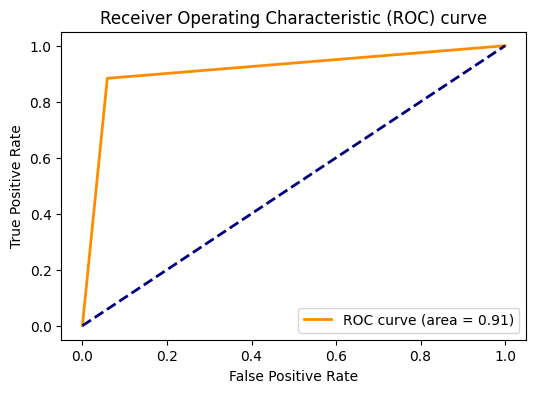

In [127]:
#Specificity
tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
print('Specificity :', tn / (tn + fp))

print("F1-score :", (f1_score(pred , test)*100).round(4), '%') #F1-score
print("Score AUC :", roc_auc_score(test, pred)) #AUC score

fpr, tpr, thresholds = roc_curve(test, pred) #Curve ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

## Comparative plots   

### Train accuracies

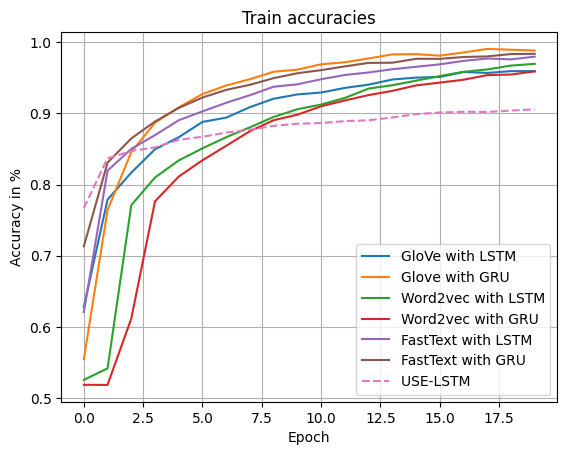

In [140]:
plt.plot(history1.history['accuracy'], label='GloVe with LSTM')
plt.plot(history2.history['accuracy'], label='Glove with GRU')
plt.plot(history3.history['accuracy'], label='Word2vec with LSTM')
plt.plot(history4.history['accuracy'], label='Word2vec with GRU')
plt.plot(history5.history['accuracy'], label='FastText with LSTM')
plt.plot(history6.history['accuracy'], label='FastText with GRU')
plt.plot(history.history['accuracy'], label='USE-LSTM ', linestyle='dashed')
plt.title('Train accuracies')
plt.ylabel('Accuracy in %')
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='lower right')

### Validation accuracies

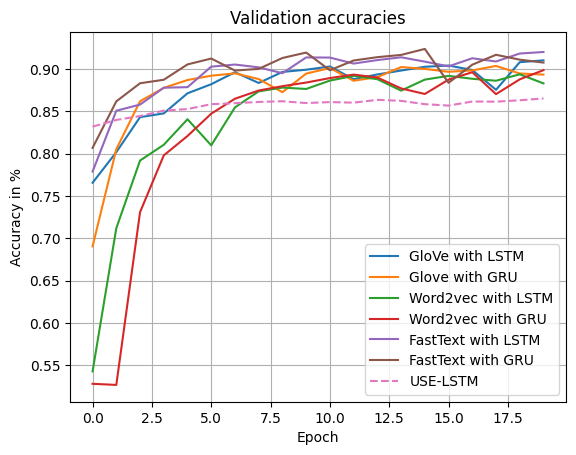

In [141]:
plt.plot(history1.history['val_accuracy'], label='GloVe with LSTM')
plt.plot(history2.history['val_accuracy'], label='Glove with GRU')
plt.plot(history3.history['val_accuracy'], label='Word2vec with LSTM')
plt.plot(history4.history['val_accuracy'], label='Word2vec with GRU')
plt.plot(history5.history['val_accuracy'], label='FastText with LSTM')
plt.plot(history6.history['val_accuracy'], label='FastText with GRU')
plt.plot(history.history['val_accuracy'], label='USE-LSTM', linestyle='dashed')
plt.title('Validation accuracies')
plt.ylabel('Accuracy in %')
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='lower right')

### Train losses

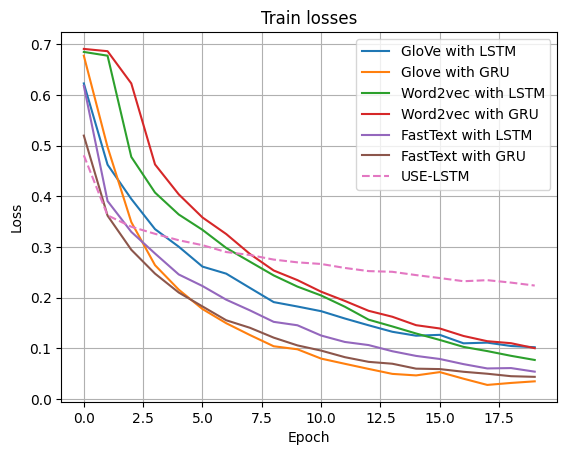

In [142]:
plt.plot(history1.history['loss'], label='GloVe with LSTM')
plt.plot(history2.history['loss'], label='Glove with GRU')
plt.plot(history3.history['loss'], label='Word2vec with LSTM')
plt.plot(history4.history['loss'], label='Word2vec with GRU')
plt.plot(history5.history['loss'], label='FastText with LSTM')
plt.plot(history6.history['loss'], label='FastText with GRU')
plt.plot(history.history['loss'], label='USE-LSTM', linestyle='dashed')
plt.title('Train losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='upper right')


### Validation losses

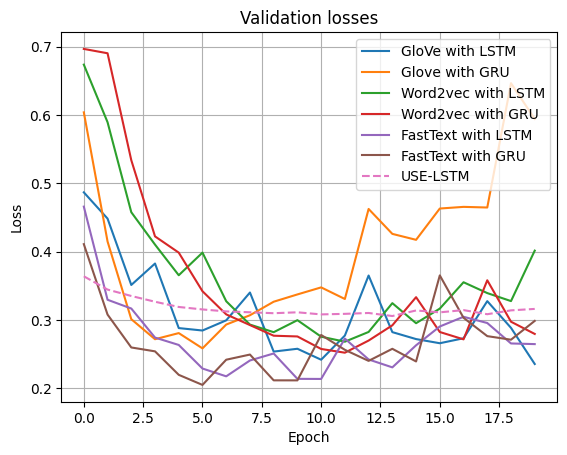

In [143]:
plt.plot(history1.history['val_loss'], label='GloVe with LSTM')
plt.plot(history2.history['val_loss'], label='Glove with GRU')
plt.plot(history3.history['val_loss'], label='Word2vec with LSTM')
plt.plot(history4.history['val_loss'], label='Word2vec with GRU')
plt.plot(history5.history['val_loss'], label='FastText with LSTM')
plt.plot(history6.history['val_loss'], label='FastText with GRU')
plt.plot(history.history['val_loss'], label='USE-LSTM', linestyle='dashed')
plt.title('Validation losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='upper right')

## Save models

In [144]:
from joblib import dump, load

dump(model, 'USE.joblib')
dump(model1, 'GloVe-LSTM.joblib')
dump(model2, 'GloVe-GRU.joblib')
dump(model3, 'Word2vec-LSTM.joblib')
dump(model4, 'Word2vec-GRU.joblib')
dump(model5, 'FastText-LSTM.joblib')
dump(model6, 'FastText-GRU.joblib')

['FastText-GRU.joblib']

In [ ]:
#Later, load the saved model and use it to make predictions
#model_1 = load('USE.joblib')
#model_1.summary()